In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sn
import matplotlib.pyplot as plt
import warnings

def invboxcox(y,lamda):
    if lamda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lamda * y + 1)/lamda)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Kostya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


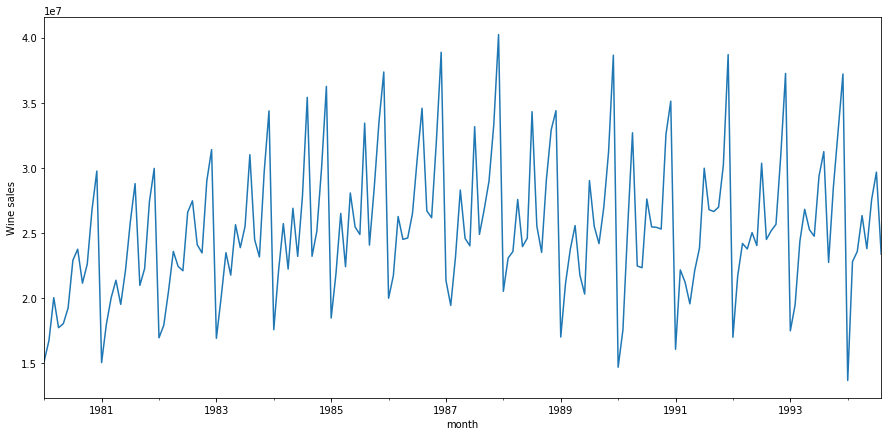

In [2]:
wine = pd.read_csv('C:/users/Kostya/python scripts/CSV/monthly-australian-wine-sales.csv'
                   , sep = ',', index_col = ['month'], parse_dates = ['month'], dayfirst = True)
wine.sales = wine.sales*1000
plt.figure(figsize(15,7))
wine.sales.plot()
plt.ylabel('Wine sales');

Есть годовая сезонность сильная , возможно есть какой-т тренд

У ряда нестационарная дисперсия, тк размах вначале меньше

Проверим стационарность

In [3]:
print(sn.tsa.stattools.adfuller(wine.sales)[1])
#гипотеза нестационарности не отвергается, однако значения пограничны

0.0511611520519


STL декомпозиция - визуально посмотреть, из каких примерно компонент состоит ряд

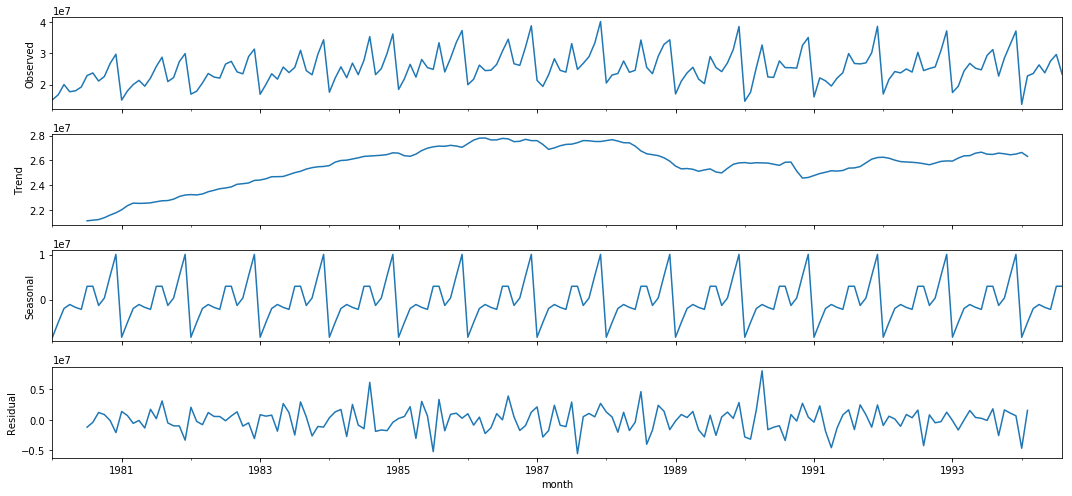

In [4]:
sn.tsa.seasonal_decompose(wine.sales).plot();

Cтабилизация дисперсии

Оптимальная lamda, box_cox : 0.236675
Критерий Дики-Фуллера : p = 0.029565


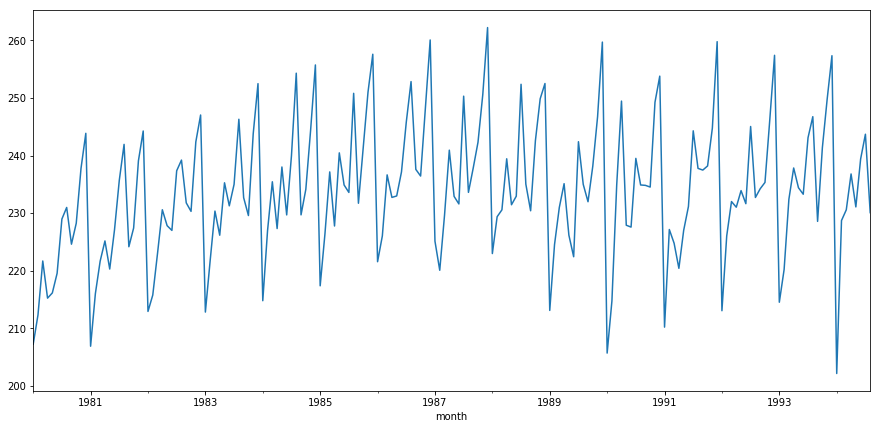

In [5]:
wine['sales_box'], lamda = stats.boxcox(wine.sales)
plt.figure(figsize(15,7))
wine.sales_box.plot();
print('Оптимальная lamda, box_cox : %f' % lamda)
print('Критерий Дики-Фуллера : p = %f' % sn.tsa.stattools.adfuller(wine.sales_box)[1])

нестационарность отвергаем => стационарен как бы. 
Но мы его не можем считать стационарным, тк есть сезонность явная и тренд
Несовершенный инструмент, если видим , что нестационарный, значит не стационарный, не верим тестам

Попробуем сезонное дифференцирование

0.12831728326916231

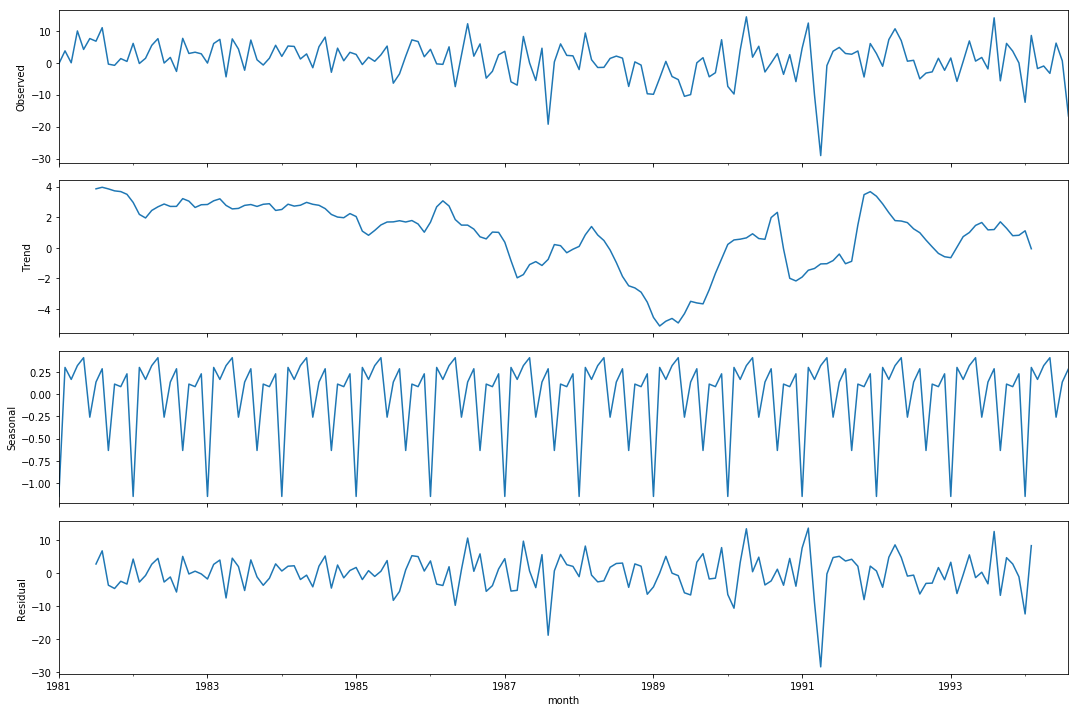

In [6]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
plt.figure(figsize(15,10))
sn.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot();
sn.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1]

На дифф ряде гипотеза нестационарности не отвергается.
Тренд сначала норм, но потом существенный провал. Значит неудивительно, что ряд нестационарный.

2.1237370026641647e-06

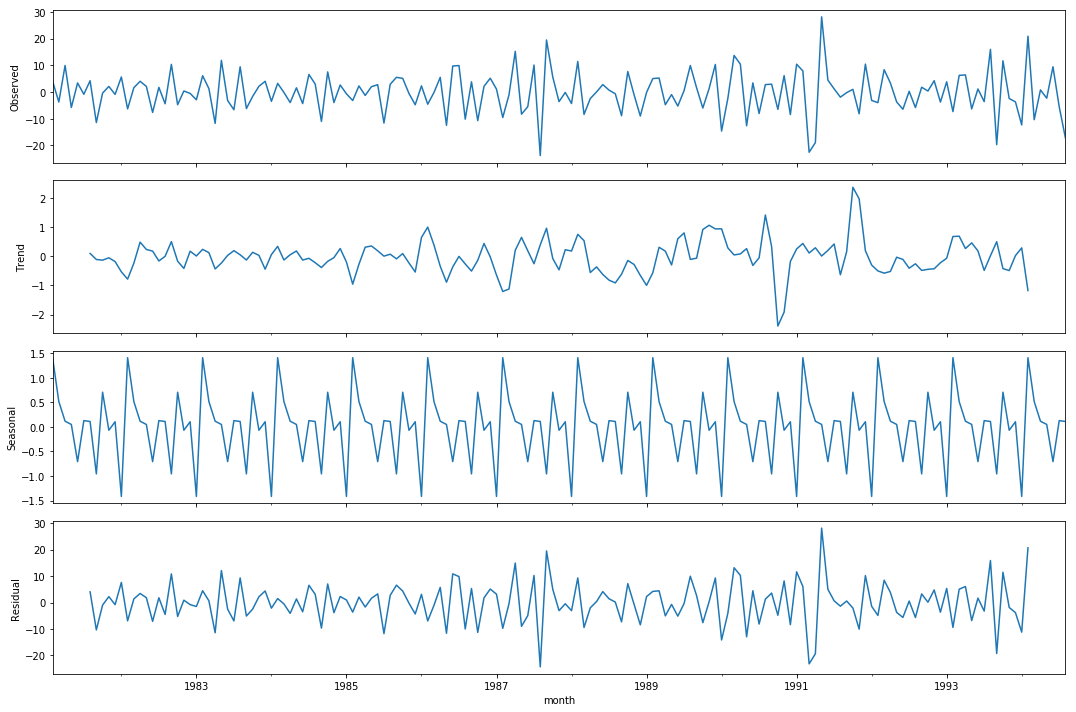

In [7]:
#добавляем обычное дифференцирование
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sn.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot();
sn.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1]

теперь точно отвергает . на тренде нет систематического поведения. берем этот ряд

## Подбор модели arima

In [8]:
#d = 1,D = 1;

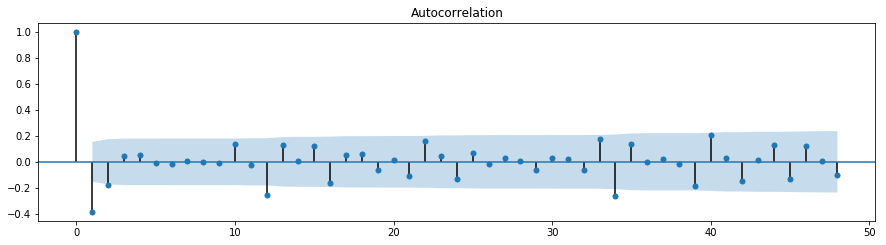

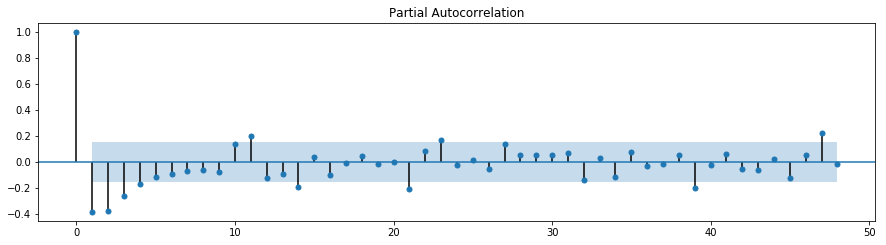

In [9]:
#смотрим автокорреляционную и частичную автокорреляционную функрию
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sn.graphics.tsa.plot_acf(wine.sales_box_diff2[13:], ax = ax, lags = 48)
pylab.show()
ax = plt.subplot(212)
sn.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), ax = ax, lags = 48)
pylab.show()

1 - кореллограммы с разным лагом.

Q - номер последнего сезонного лага, при котором корреляция значима. Q = 1(12)

q - номер последнего несезонного лага, при котором корреляция значима. q = 2(1е два отличаются значимо)

P - номер последнего сезонного лага, при котором автокорреляция значима. 12 лаг, берем P = 1

p - номер последнего несезонного лага, при котором автокорреляция значима. 4 лаг, берем p = 4

Перебор с этими нач приближениями:


In [30]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = list(range(0, 2))

In [47]:
from itertools import product
parameters = product(ps,qs,Ps,Qs)
parameters = list(parameters)
len(parameters)

60

In [52]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается(расходится)
    try:
        model=sn.tsa.statespace.SARIMAX(wine.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 25.7 s


In [64]:
result_table=pd.DataFrame(results)
result_table.columns = ['params', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

params          aic
24  (2, 1, 0, 1)  1007.801553
26  (2, 1, 1, 1)  1008.786538
28  (2, 2, 0, 1)  1009.284267
36  (3, 1, 0, 1)  1009.723537
6   (0, 1, 1, 1)  1010.126754

In [65]:
best_model.summary()
#Ljung-Box (Q): 	40.31
#Prob(Q): 	0.46 видимо остатки модели не автокоррелированы

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -498.901
Date:                            Wed, 24 Oct 2018   AIC                           1007.802
Time:                                    21:39:36   BIC                           1023.654
Sample:                                01-01-1980   HQIC                          1014.231
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111     -1.800      0.072      -0.416       0.018
ma.L1         -0.8394      0.055    -15.258      0.000      -0.947      -0.732
ma.S.L12      -0.6688      0.052    -12.746      0.000      -0.772      -0.566
sigma2        25.2278      2.144     11.768      0.000      21.026      29.429
===================================================================================
Ljung-Box (Q):                       40.31   Jarque-Bera (JB):                25.57
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.257989456681
1.84446514639e-23


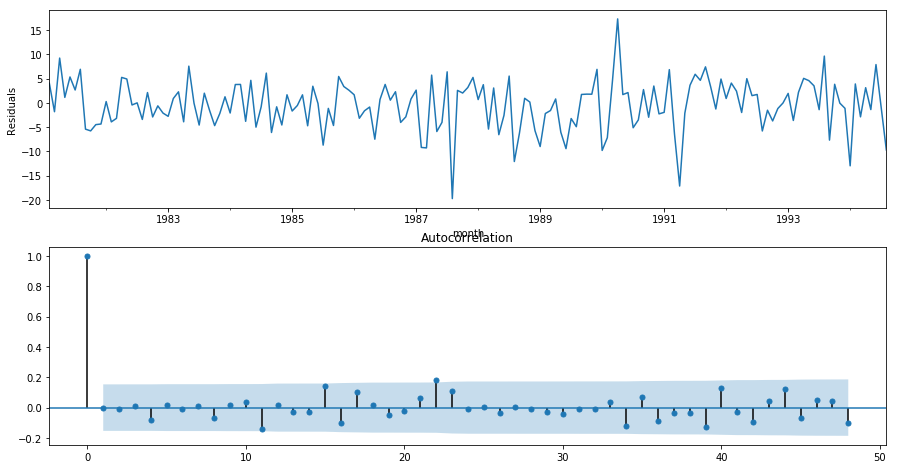

In [76]:
#визуальный анализ остатков
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sn.graphics.tsa.plot_acf(best_model.resid[13:], lags = 48, ax = ax)

print(stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(sn.tsa.stattools.adfuller(best_model.resid[13:])[1])
#остатки похожи на шум, и автокорр функция норм. лаги бывает отличаются от нуля, но они дадеко. 
#тем более лаг не сезонный. а еше множеств проверка гипотез
#стьюдент - остатки не смещены
#фуллер - отвергает нестационарность. 
#Неавтокоррелированны(критерий Ljung-Box и коррелограмма)

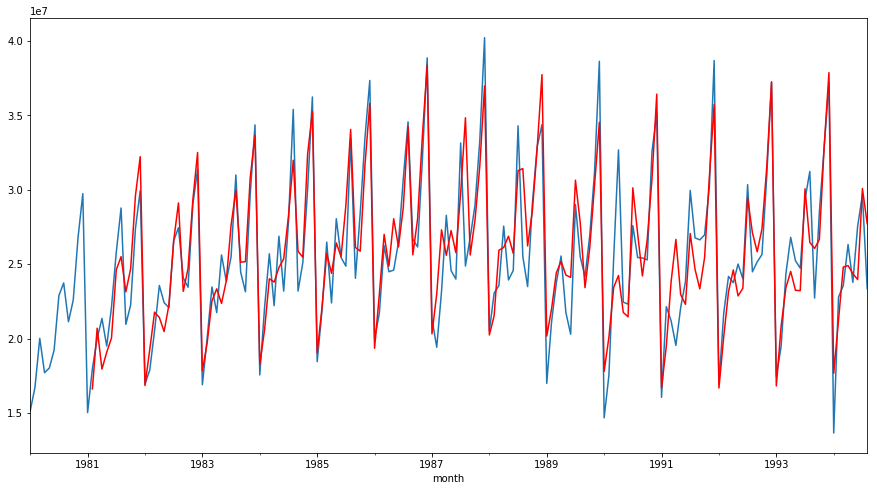

In [77]:
wine['model'] = invboxcox(best_model.fittedvalues, lamda)
wine.sales.plot()
wine.model[13:].plot(color = 'r')


## Прогноз

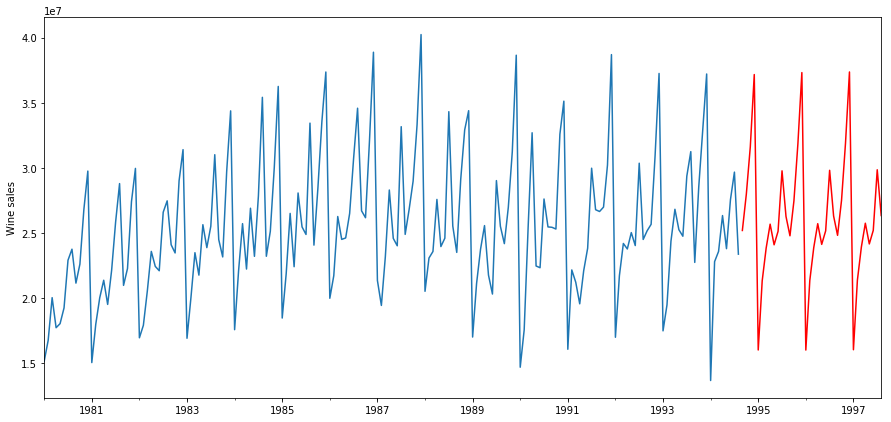

In [79]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lamda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()